### 导入包

In [1]:
# 导入相关包
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

### 读取数据

In [2]:
path = './data/'

#####train
trn_click = pd.read_csv(path+'train_click_log.csv')
item_df = pd.read_csv(path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv(path+'articles_emb.csv')

#####test
tst_click = pd.read_csv(path+'testA_click_log.csv')

### 数据预处理
计算用户点击rank和点击次数

In [3]:
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [4]:
#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

### 数据浏览
### 用户点击日志文件_训练集

In [5]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


train_click_log.csv文件数据中每个字段的含义

* user_id: 用户的唯一标识
* click_article_id: 用户点击的文章唯一标识
* click_timestamp: 用户点击文章时的时间戳
* click_environment: 用户点击文章的环境
* click_deviceGroup: 用户点击文章的设备组
* click_os: 用户点击文章时的操作系统
* click_country: 用户点击文章时的所在的国家
* click_region: 用户点击文章时所在的区域
* click_referrer_type: 用户点击文章时，文章的来源

In [6]:
#用户点击日志信息
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
user_id                1112623 non-null int64
click_article_id       1112623 non-null int64
click_timestamp        1112623 non-null int64
click_environment      1112623 non-null int64
click_deviceGroup      1112623 non-null int64
click_os               1112623 non-null int64
click_country          1112623 non-null int64
click_region           1112623 non-null int64
click_referrer_type    1112623 non-null int64
rank                   1112623 non-null int64
click_cnts             1112623 non-null int64
category_id            1112623 non-null int64
created_at_ts          1112623 non-null int64
words_count            1112623 non-null int64
dtypes: int64(14)
memory usage: 127.3 MB


In [8]:
trn_click.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1112623.0,1.221198e+05,5.540349e+04,0.000000e+00,7.934700e+04,1.309670e+05,1.704010e+05,1.999990e+05
click_article_id,1112623.0,1.951541e+05,9.292286e+04,3.000000e+00,1.239090e+05,2.038900e+05,2.777120e+05,3.640460e+05
click_timestamp,1112623.0,1.507588e+12,3.363466e+08,1.507030e+12,1.507297e+12,1.507596e+12,1.507841e+12,1.510603e+12
click_environment,1112623.0,3.947786e+00,3.276715e-01,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
click_deviceGroup,1112623.0,1.815981e+00,1.035170e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00
click_os,1112623.0,1.301976e+01,6.967844e+00,2.000000e+00,2.000000e+00,1.700000e+01,1.700000e+01,2.000000e+01
click_country,1112623.0,1.310776e+00,1.618264e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
click_region,1112623.0,1.813587e+01,7.105832e+00,1.000000e+00,1.300000e+01,2.100000e+01,2.500000e+01,2.800000e+01
click_referrer_type,1112623.0,1.910063e+00,1.220012e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00
rank,1112623.0,7.118518e+00,1.016095e+01,1.000000e+00,2.000000e+00,4.000000e+00,8.000000e+00,2.410000e+02


In [9]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [10]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

### 画直方图大体看一下基本的属性分布

<Figure size 432x288 with 0 Axes>

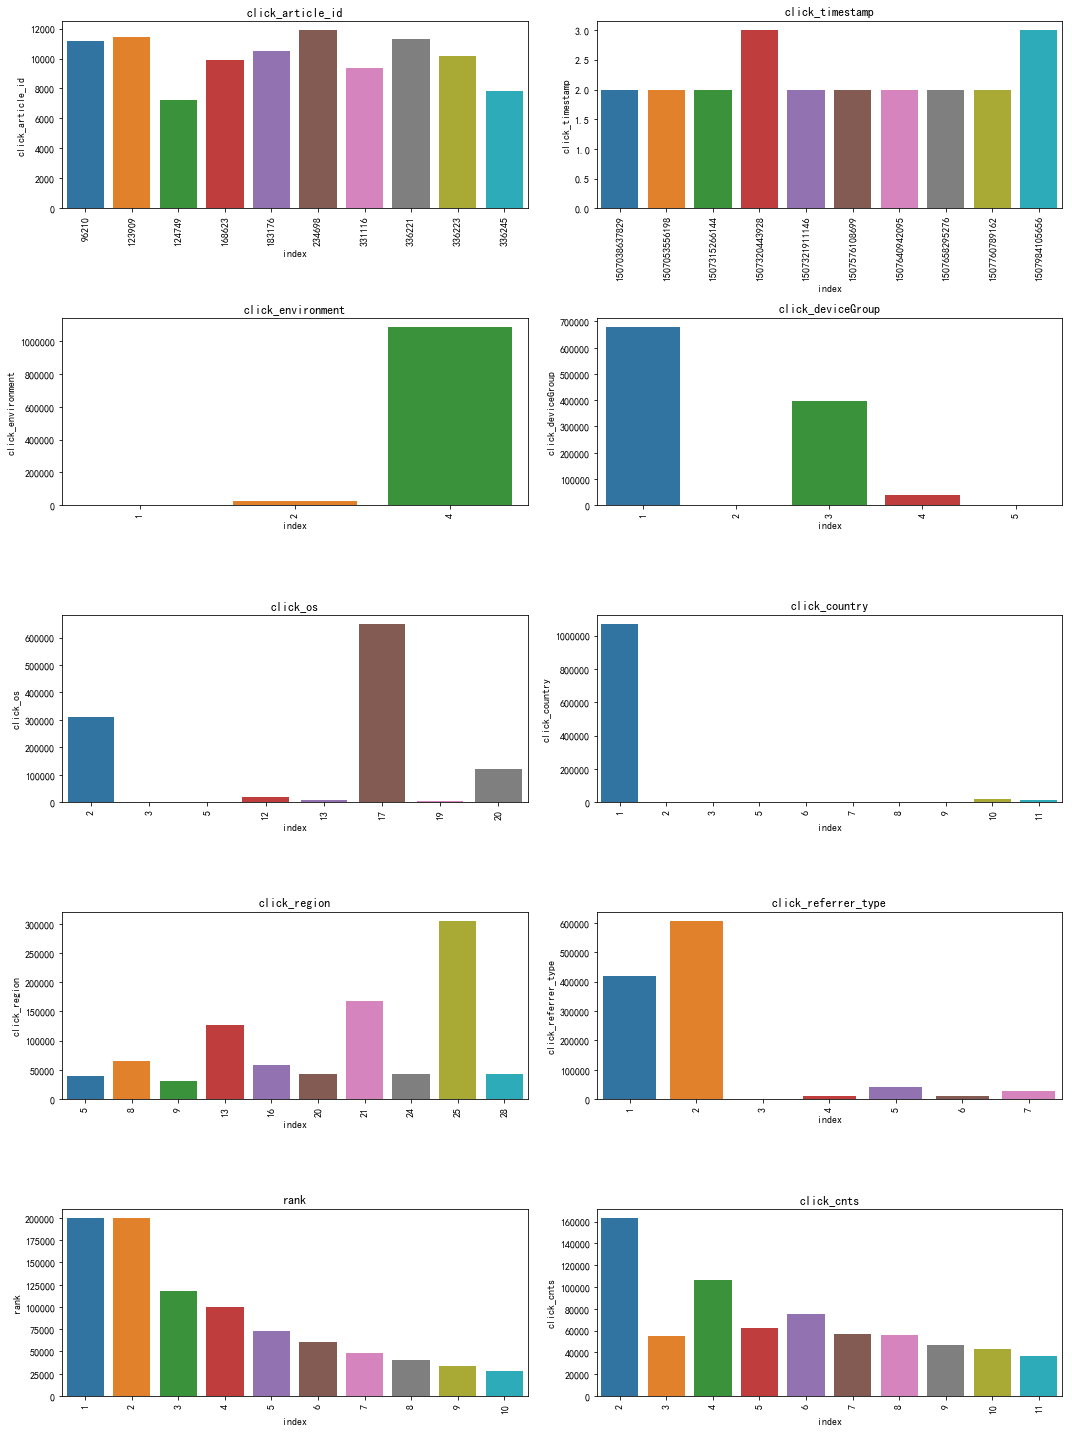

In [14]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

从点击时间clik_timestamp来看，分布较为平均，可不做特殊处理。由于时间戳是13位的，后续将时间格式转换成10位方便计算。

从点击环境click_environment来看，仅有1922次（占0.1%）点击环境为1；仅有24617次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4。

从点击设备组click_deviceGroup来看，设备1占大部分（60.4%），设备3占36%。

测试集用户点击日志

In [15]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [16]:
tst_click.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,518010.0,2.273424e+05,1.461391e+04,2.000000e+05,2.149260e+05,2.291090e+05,2.401820e+05,2.499990e+05
click_article_id,518010.0,1.938038e+05,8.827939e+04,1.370000e+02,1.285510e+05,1.991970e+05,2.721430e+05,3.640430e+05
click_timestamp,518010.0,1.507387e+12,3.706127e+08,1.506959e+12,1.507026e+12,1.507308e+12,1.507666e+12,1.508832e+12
click_environment,518010.0,3.947300e+00,3.239161e-01,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
click_deviceGroup,518010.0,1.738285e+00,1.020858e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00
click_os,518010.0,1.362847e+01,6.625564e+00,2.000000e+00,1.200000e+01,1.700000e+01,1.700000e+01,2.000000e+01
click_country,518010.0,1.348209e+00,1.703524e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.100000e+01
click_region,518010.0,1.825025e+01,7.060798e+00,1.000000e+00,1.300000e+01,2.100000e+01,2.500000e+01,2.800000e+01
click_referrer_type,518010.0,1.819614e+00,1.082657e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00
rank,518010.0,1.552179e+01,3.395770e+01,1.000000e+00,4.000000e+00,8.000000e+00,1.800000e+01,9.380000e+02


我们可以看出训练集和测试集的用户是完全不一样的

训练集的用户ID由0 ~ 199999，而测试集A的用户ID由200000 ~ 249999。

In [19]:
#测试集中的用户数量为5w
tst_click.user_id.nunique()

50000

In [20]:
tst_click.groupby('user_id')['click_article_id'].count().min() # 注意测试集里面有只点击过一次文章的用户

1

### 新闻文章信息数据表

In [21]:
#新闻文章数据集浏览
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


In [22]:
item_df['words_count'].value_counts()

176     3485
182     3480
179     3463
178     3458
174     3456
183     3432
184     3427
173     3414
180     3403
177     3391
170     3387
187     3355
169     3352
185     3348
175     3346
181     3330
186     3328
189     3327
171     3327
172     3322
165     3308
188     3288
167     3269
190     3261
192     3257
168     3248
193     3225
166     3199
191     3182
194     3164
        ... 
601        1
857        1
1977       1
1626       1
697        1
1720       1
696        1
706        1
592        1
1605       1
586        1
582        1
1606       1
972        1
716        1
584        1
1608       1
715        1
841        1
968        1
964        1
587        1
1099       1
1355       1
711        1
845        1
710        1
965        1
847        1
1535       1
Name: words_count, Length: 866, dtype: int64

461


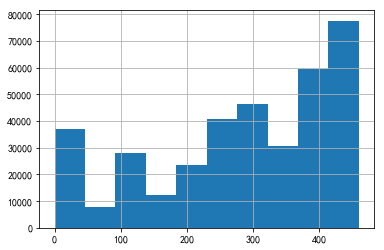

In [23]:
print(item_df['category_id'].nunique())     # 461个文章主题
item_df['category_id'].hist()

In [24]:
item_df.shape       # 364047篇文章

(364047, 4)

### 新闻文章embedding向量表示

In [25]:
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [26]:
item_emb_df.shape

(364047, 251)

### 数据分析
### 用户重复点击

In [27]:
#####merge
user_click_merge = trn_click.append(tst_click)

In [28]:
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [29]:
user_click_count[user_click_count['count']>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [30]:
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13])

In [31]:
#用户点击新闻次数
user_click_count.loc[:,'count'].value_counts() 

1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

可以看出：有1605541（约占99.2%）的用户未重复阅读过文章，仅有极少数用户重复点击过某篇文章。 这个也可以单独制作成特征

### 用户点击环境变化分析

In [32]:
def plot_envs(df, cols, r, c):
    plt.figure()
    plt.figure(figsize=(10, 5))
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index()
        fig = sns.barplot(x=v['index'], y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

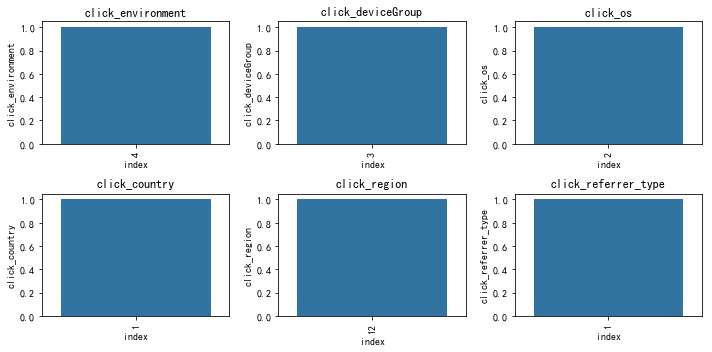

<Figure size 432x288 with 0 Axes>

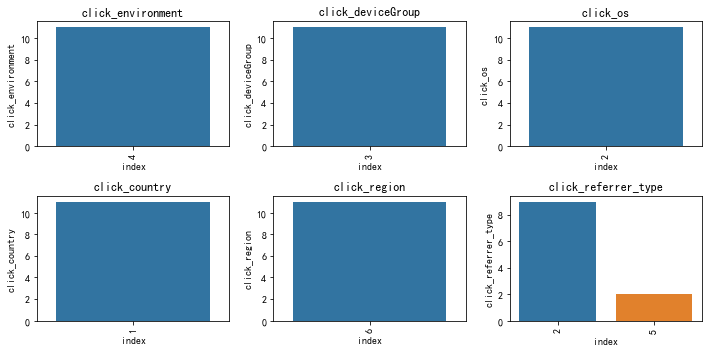

<Figure size 432x288 with 0 Axes>

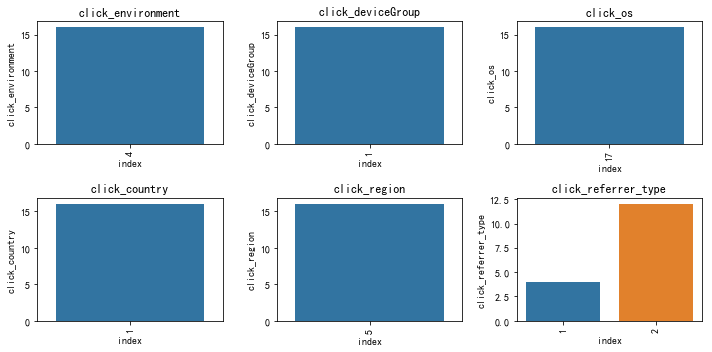

<Figure size 432x288 with 0 Axes>

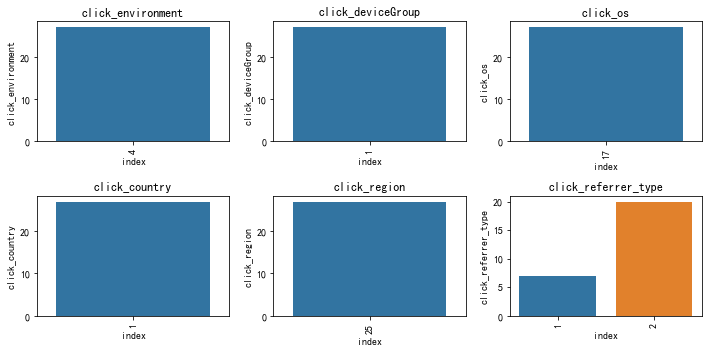

<Figure size 432x288 with 0 Axes>

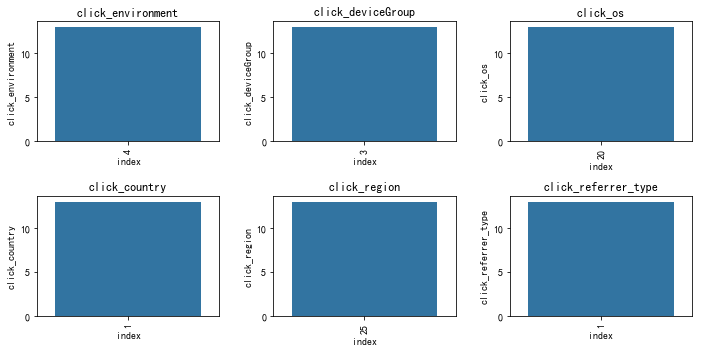

In [33]:
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=5, replace=False)
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)

可以看出绝大多数数的用户的点击环境是比较固定的。思路：可以基于这些环境的统计特征来代表该用户本身的属性

### 用户点击新闻数量的分布

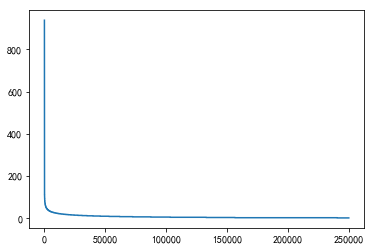

In [34]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count)

可以根据用户的点击文章次数看出用户的活跃度

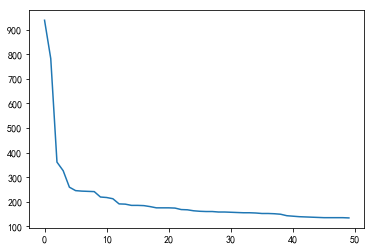

In [36]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

点击次数排前50的用户的点击次数都在100次以上。思路：我们可以定义点击次数大于等于100次的用户为活跃用户，这是一种简单的处理思路， 判断用户活跃度，更加全面的是再结合上点击时间，后面我们会基于点击次数和点击时间两个方面来判断用户活跃度。



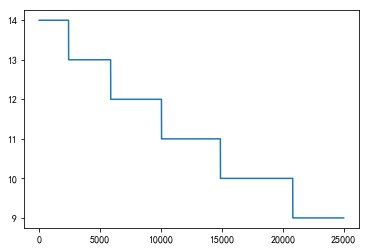

In [37]:
#点击次数排名在[25000:50000]之间
plt.plot(user_click_item_count[25000:50000])

可以看出点击次数小于等于两次的用户非常的多，这些用户可以认为是非活跃用户

### 新闻点击次数分析

In [38]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)

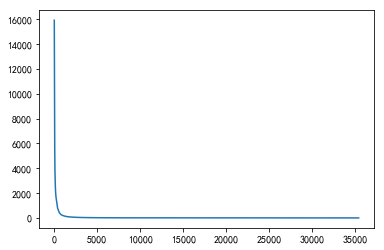

In [39]:
plt.plot(item_click_count)

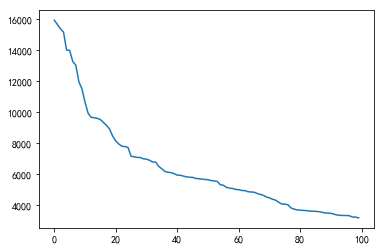

In [40]:
plt.plot(item_click_count[:100])

可以看出点击次数最多的前100篇新闻，点击次数大于1000次

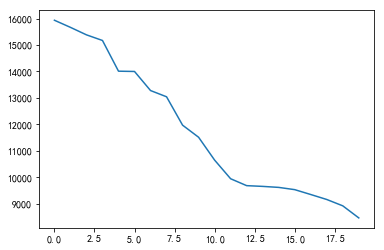

In [41]:
plt.plot(item_click_count[:20])

点击次数最多的前20篇新闻，点击次数大于2500。思路：可以定义这些新闻为热门新闻， 这个也是简单的处理方式，后面我们也是根据点击次数和时间进行文章热度的一个划分。

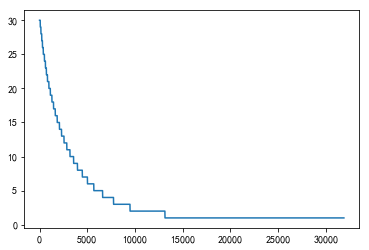

In [42]:
plt.plot(item_click_count[3500:])


可以发现很多新闻只被点击过一两次。思路：可以定义这些新闻是冷门新闻。

### 新闻共现频次：两篇新闻连续出现的次数

In [44]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


由统计数据可以看出，平均共现次数2.88，最高为1687。

说明用户看的新闻，相关性是比较强的。

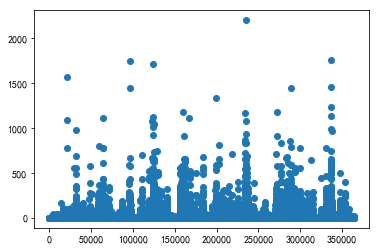

In [45]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)

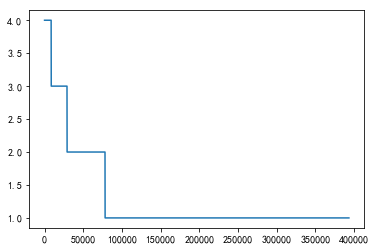

In [46]:
plt.plot(union_item['count'].values[40000:])

大概有70000个pair至少共现一次。

### 新闻文章信息

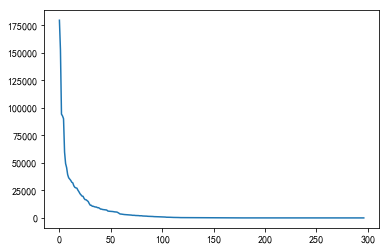

In [47]:
#不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

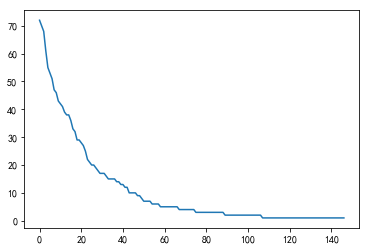

In [48]:
#出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [49]:
#新闻字数的描述性统计
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

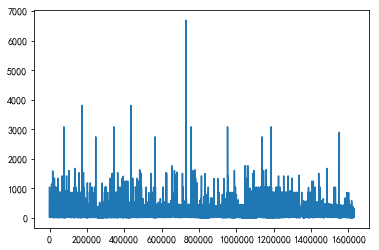

In [50]:
plt.plot(user_click_merge['words_count'].values)


### 用户点击的新闻类型的偏好
此特征可以用于度量用户的兴趣是否广泛。

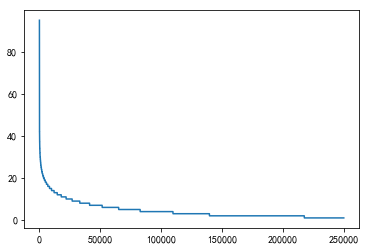

In [51]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))


从上图中可以看出有一小部分用户阅读类型是极其广泛的，大部分人都处在20个新闻类型以下。



In [52]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()


,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


### 用户查看文章的长度的分布
通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣。

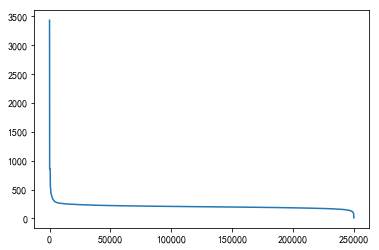

In [53]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))

从上图中可以发现有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低。

大多数人偏好于阅读字数在200-400字之间的新闻。

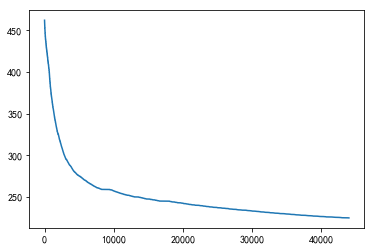

In [55]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])


可以发现大多数人都是看250字以下的文章

In [56]:
#更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


### 用户点击新闻的时间分析


In [57]:
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge = user_click_merge.sort_values('click_timestamp')

In [58]:
user_click_merge.head()


,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
18,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
2,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
30,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
50,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
25,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


In [59]:
def mean_diff_time_func(df, col):
    df = pd.DataFrame(df, columns={col})
    df['time_shift1'] = df[col].shift(1).fillna(0)
    df['diff_time'] = abs(df[col] - df['time_shift1'])
    return df['diff_time'].mean()

In [60]:
# 点击时间差的平均值
mean_diff_click_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'click_timestamp'))

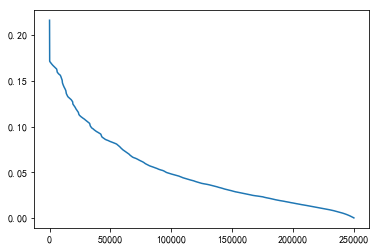

In [61]:
plt.plot(sorted(mean_diff_click_time.values, reverse=True))


从上图可以发现不同用户点击文章的时间差是有差异的。

In [62]:
# 前后点击文章的创建时间差的平均值
mean_diff_created_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'created_at_ts'))

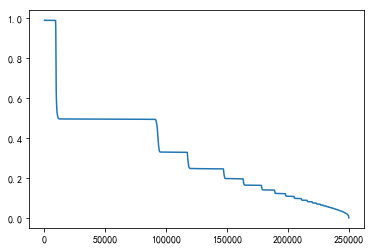

In [63]:
plt.plot(sorted(mean_diff_created_time.values, reverse=True))

从图中可以发现用户先后点击文章，文章的创建时间也是有差异的



In [64]:
# 用户前后点击文章的相似性分布
item_idx_2_rawid_dict = dict(zip(item_emb_df['article_id'], item_emb_df.index))

In [65]:
del item_emb_df['article_id']

In [66]:
item_emb_np = np.ascontiguousarray(item_emb_df.values, dtype=np.float32)

In [67]:
# 随机选择5个用户，查看这些用户前后查看文章的相似性
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
25530,239877,225055,0.002160,4,1,17,1,16,2,8,8,354,0.989211,245
25531,239877,272660,0.002168,4,1,17,1,16,2,7,8,399,0.989007,246
35333,236251,207731,0.003961,4,1,17,1,6,1,10,10,331,0.989213,166
35334,236251,209294,0.003962,4,1,17,1,6,1,9,10,332,0.989223,216
35335,236251,225055,0.003989,4,1,17,1,6,1,8,10,354,0.989211,245


In [68]:
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values
    for i in range(0, len(item_list)-1):
        emb1 = item_emb_np[item_idx_2_rawid_dict[item_list[i]]]
        emb2 = item_emb_np[item_idx_2_rawid_dict[item_list[i+1]]]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    sim_list.append(0)
    return sim_list

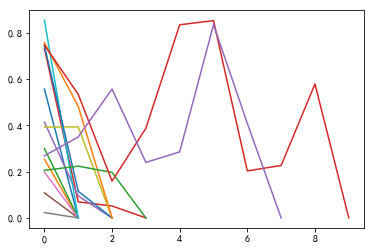

In [69]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)

从图中可以看出有些用户前后看的商品的相似度波动比较大，有些波动比较小，也是有一定的区分度的。

### 总结
通过数据分析的过程， 我们目前可以得到以下几点重要的信息， 这个对于我们进行后面的特征制作和分析非常有帮助：

* 训练集和测试集的用户id没有重复，也就是测试集里面的用户模型是没有见过的
* 训练集中用户最少的点击文章数是2， 而测试集里面用户最少的点击文章数是1
* 用户对于文章存在重复点击的情况， 但这个都存在于训练集里面
* 同一用户的点击环境存在不唯一的情况，后面做这部分特征的时候可以采用统计特征
* 用户点击文章的次数有很大的区分度，后面可以根据这个制作衡量用户活跃度的特征
* 文章被用户点击的次数也有很大的区分度，后面可以根据这个制作衡量文章热度的特征
* 用户看的新闻，相关性是比较强的，所以往往我们判断用户是否对某篇文章感兴趣的时候， 在很大程度上会和他历史点击过的文章有关
* 用户点击的文章字数有比较大的区别， 这个可以反映用户对于文章字数的区别
* 用户点击过的文章主题也有很大的区别， 这个可以反映用户的主题偏好
* 不同用户点击文章的时间差也会有所区别， 这个可以反映用户对于文章时效性的偏好
所以根据上面的一些分析，可以更好的帮助我们后面做好特征工程， 充分挖掘数据的隐含信息。